# Media GeoTag Mapper (MGTM):

A Python tool for retrieving, storing, and viewing image and video geotags

By Kenneth Burchfiel

Released under the MIT license

GitHub link: https://github.com/kburchfiel/media_geotag_mapper


This tutorial notebook shows how to use the functions in media_mapper_functions.py to retrieve geographic coordinates from your images and videos, then store them and view them as interactive maps.

For this tutorial, I'll be loading geotags from video clips and images that I've taken since June 2012. Most of the devices are Samsung Galaxy phones, but I'll also import images from my old Sony HDR-CX260V video camera, which predates my first smartphone.

The steps for analyzing and mapping iPhone data are very similar, but you'll probably want to sort the data differently. For more information, see the media_geotag_mapper_iPhone_example notebook. The documentation, comments, and output in this tutorial will still prove to be a helpful reference for iPhone users.

First, I'll import a series of libraries:


In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import display

from media_geotag_functions_v2 import generate_media_list, \
    retrieve_pic_locations, retrieve_clip_locations, generate_loc_list, \
    map_media_locations, folder_list_to_map, flip_lon, create_map_screenshot, \
    calculate_distance_by_year, convert_png_to_smaller_jpg, \
    batch_create_map_screenshots, batch_convert_pngs_to_smaller_jpgs

Next, I'll create a list of the folder paths on my external hard drive that contain the images and video clips from which I'll want to extract geotag data. Since I import my media into device-specific folders, the folder names also show the various devices that I'll be using.

In [2]:
folder_name = 'combined'

top_folder_list = [
r'H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1 Sony HDRCX260V', 
r'H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\2 Samsung Galaxy S4 Mini', 
r'H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\28 Samsung Galaxy S5', 
r'H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\30 Samsung Galaxy S7', 
r'H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\34 Galaxy S21 Ultra', 
r'H:\D2V1\Vids Clips Pics\2 Unsorted Clips\2 Samsung Galaxy S4 Mini', 
r'H:\D2V1\Vids Clips Pics\2 Unsorted Clips\28 Samsung Galaxy S5', 
r'H:\D2V1\Vids Clips Pics\2 Unsorted Clips\30 Samsung Galaxy S7', 
r'H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Galaxy S21 Ultra',
r'H:\D2V1\Vids Clips Pics\2 Unsorted Clips\39 Samsung Galaxy S24 Ultra']

The following variable governs whether or not to create a new set of media and locations lists. This process can take a while and also requires access to the original media files, so it's best to run it once and then comment it out until you have new media to add.

In [3]:
generate_new_lists = True

The following cell calls generate_media_list in order to obtain a list of all files within these folders (and their corresponding subfolders). It also saves this file list as a .csv file. 

In [4]:
if generate_new_lists == True:
    df_media = generate_media_list(top_folder_list=top_folder_list,
    folder_name = folder_name)

Here's a look at df_media. generate_loc_list iterates through this table in order to extract geotag data.

In [5]:
df_media = pd.read_csv(f'{folder_name}_media_list.csv')
df_media.head(5)

path          name  \
0  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...  DSC00001.JPG   
1  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...  DSC00002.JPG   
2  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...  DSC00003.JPG   
3  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...  DSC00004.JPG   
4  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...  DSC00005.JPG   

                 ctime        modified_time        accessed_time  megabytes  \
0  2019-02-23 00:34:11  2012-06-25 20:21:40  2024-01-05 00:35:48   2.812600   
1  2019-02-23 00:34:11  2012-06-25 20:21:44  2024-01-05 00:35:48   3.246815   
2  2019-02-23 00:34:11  2012-06-25 20:24:34  2024-01-05 00:35:48   2.818006   
3  2019-02-23 00:34:11  2012-06-25 20:24:38  2024-01-05 00:35:48   2.730064   
4  2019-02-23 00:34:11  2012-06-25 20:24:40  2024-01-05 00:35:48   2.862829   

  extension type  
0       jpg  pic  
1       jpg  pic  
2       jpg  pic  
3       jpg  pic  
4       jpg  pic

The following cell removes two types of files from df_media.

Thousands of my images are simply copies of the first frame of videos; these images, which are stored within a '1st_Frames' folder, don't have location data and thus shouldn't be processed by generate_loc_list() below. Therefore, the cell excludes any item with '1st_Frames' in its path.

Next, the cell removes files that were created as video captures of .mp4 videos on a Samsung Galaxy phone. Although these files often contain location data, the time that a given video capture was created does **not** match the time that the original video file was created. Therefore, including them will cause maps to be drawn incorrectly. (Also, since the video files on which these video capture files are based already contain location data, the video capture's geotag data are redundant.)

You'll likely want to modify this cell to fit your own filtering needs.


In [6]:
print(len(df_media)) # These print statements will help ensure that the code
# is successfully removing unwanted files from df_media.
df_media = df_media[
df_media['path'].str.contains('1st_Frames') == False].copy()
print(len(df_media))
df_media = df_media[
df_media['path'].str.lower().str.contains('videocapture') == False].copy()
print(len(df_media))

64396
57202
48632


The next cell calls generate_loc_list to search for geographic coordinate data stored within the EXIF data/metadata of each image and video file, then stores those coordinates within another .csv file. This cell can take a while to run depending on the number of media files through which it needs to search.

In [7]:
if generate_new_lists == True:
    df_all_locations = generate_loc_list(df_media = df_media, 
    folder_name = folder_name)

Retrieving picture locations:


100%|██████████| 32862/32862 [14:53<00:00, 36.77it/s]  


Retrieving clip locations:


100%|██████████| 15721/15721 [23:38<00:00, 11.08it/s] 


The following cell creates a subset of df_media that shows my video and image files from a trip to Israel in March 2022. It also saves this subset to a .csv file so that you can see what the structure of df_media looks like.

In [8]:
df_media_israel = df_media.query(
    "modified_time > '2022-03-11 15:30' & modified_time < '2022-03-18'").copy()
df_media_israel.to_csv('df_media_israel.csv', index = False)
df_media_israel


path                 name  \
42971  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\3...  20220311_223743.jpg   
42972  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\3...  20220311_223749.jpg   
42973  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\3...  20220312_102426.jpg   
42974  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\3...  20220312_102428.jpg   
42975  H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\3...  20220312_121137.jpg   
...                                                  ...                  ...   
60463  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055031.mp4   
60464  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055053.mp4   
60465  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055118.mp4   
60466  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055138.mp4   
60467  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055615.mp4   

                     ctime        modified_time        accessed_time  \
42971  2022-03-18 17:47:27  2022-03-11 22:37:46  2024-01-05 00:54:10   
42972  2022-03-18 17:47:27  2022-03-11 22:37:50  2024-01-05 00:54:10   
42973  2022-03-18 17:47:27  2022-03-12 10:24:26  2024-01-05 00:54:10   
42974  2022-03-18 17:47:27  2022-03-12 10:24:29  2024-01-05 00:54:11   
42975  2022-03-18 17:47:27  2022-03-12 12:11:39  2024-01-05 00:54:11   
...                    ...                  ...                  ...   
60463  2022-03-18 17:35:12  2022-03-17 23:50:45  2024-01-05 01:23:08   
60464  2022-03-18 17:35:13  2022-03-17 23:51:02  2024-01-05 01:23:08   
60465  2022-03-18 17:35:14  2022-03-17 23:51:24  2024-01-05 01:23:08   
60466  2022-03-18 17:35:14  2022-03-17 23:51:46  2024-01-05 01:23:08   
60467  2022-03-18 17:35:15  2022-03-17 23:56:22  2024-01-05 01:23:08   

        megabytes extension  type  
42971   25.171938       jpg   pic  
42972    1.909092       jpg   pic  
42973    2.349057       jpg   pic  
42974    2.361671       jpg   pic  
42975    2.406379       jpg   pic  
...           ...       ...   ...  
60463  125.635733       mp4  clip  
60464   77.499335       mp4  clip  
60465   55.145896       mp4  clip  
60466   64.585904       mp4  clip  
60467   55.931513       mp4  clip  

[654 rows x 8 columns]

I'll next create df_all_locations, a DataFrame containing all location data provided for the files in df_media. I'll limit the sample output of this notebook to geotags taken within Colorado.

In [9]:
co_min_lat = 37
co_max_lat = 41
co_min_lon = -1*((109)+(2/60)+(48/3600))
co_max_lon = -1*((102)+(2/60)+(48/3600))
# These are the boundaries of Colorado set by Congress in 1861. The 
# modern boundaries probably differ slightly. See
# https://en.wikipedia.org/wiki/Colorado#Geography

In [10]:
df_all_locations = pd.read_csv(f'{folder_name}_media_locations.csv')
df_all_locations.query("lat >= @co_min_lat & lat <= @co_max_lat & \
lon >= @co_min_lon & lon <= @co_max_lon")

path                 name  \
1035   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01036.JPG   
1036   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01037.JPG   
1037   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01038.JPG   
1038   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01039.JPG   
1039   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01040.JPG   
...                                                  ...                  ...   
43897  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220305_201836.mp4   
43898  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220305_202156.mp4   
43899  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220306_062843.mp4   
43900  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220306_070529.mp4   
43901  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220306_070536.mp4   

                     ctime        modified_time        accessed_time  \
1035   2019-02-23 00:35:51  2012-12-16 21:29:34  2024-01-05 00:35:51   
1036   2019-02-23 00:35:51  2012-12-16 21:29:42  2024-01-05 00:35:51   
1037   2019-02-23 00:35:51  2012-12-16 21:30:02  2024-01-05 00:35:51   
1038   2019-02-23 00:35:51  2012-12-16 21:34:30  2024-01-05 00:35:51   
1039   2019-02-23 00:35:52  2012-12-16 21:34:42  2024-01-05 00:35:51   
...                    ...                  ...                  ...   
43897  2022-03-07 16:00:24  2022-03-05 22:18:40  2024-01-05 01:21:41   
43898  2022-03-07 16:00:25  2022-03-05 22:22:02  2024-01-05 01:21:41   
43899  2022-03-07 16:00:25  2022-03-06 08:28:51  2024-01-05 01:21:41   
43900  2022-03-07 16:00:25  2022-03-06 09:05:34  2024-01-05 01:21:41   
43901  2022-03-07 16:00:25  2022-03-06 09:05:40  2024-01-05 01:21:41   

       megabytes extension  type        raw_location        lat         lon  \
1035    1.815763       jpg   pic                   0  40.541800 -102.062050   
1036    2.493354       jpg   pic                   0  40.538069 -102.082196   
1037    1.746941       jpg   pic                   0  40.528293 -102.135088   
1038    2.071690       jpg   pic                   0  40.520737 -102.175474   
1039    2.009213       jpg   pic                   0  40.520737 -102.175474   
...          ...       ...   ...                 ...        ...         ...   
43897  14.585707       mp4  clip  +39.1875-106.8227/  39.187500 -106.822700   
43898  23.778639       mp4  clip  +39.1860-106.8231/  39.186000 -106.823100   
43899  67.196104       mp4  clip  +39.1857-106.8236/  39.185700 -106.823600   
43900  38.578098       mp4  clip  +39.1867-106.8231/  39.186700 -106.823100   
43901  36.135166       mp4  clip  +39.1867-106.8231/  39.186700 -106.823100   

          alt_capture_time  
1035   2012-12-16 21:29:35  
1036   2012-12-16 21:29:42  
1037   2012-12-16 21:30:03  
1038   2012-12-16 21:34:30  
1039   2012-12-16 21:34:42  
...                    ...  
43897                    x  
43898                    x  
43899                    x  
43900                    x  
43901                    x  

[1498 rows x 12 columns]

When mapping the geotags shown in df_all_locations, I realized that some pictures had a positive (East) longitude when they should have had a negative (West) longitude. This was apparently due to an error in the original geotag data. Therefore, I created a function called flip_lon that reversed the longitude coordinates of geotags that appeared in a certain frame. Like the other functions, I stored it within media_mapper_functions.py.

In [11]:
if generate_new_lists == True:
    df_all_locations = flip_lon(df_all_locations, lat_south_bound = 25,
    lat_north_bound = 45, lon_west_bound = 70, lon_east_bound = 95)
    df_all_locations.to_csv(f'{folder_name}_media_locations.csv', index = False)
    df_all_locations = pd.read_csv(f'{folder_name}_media_locations.csv')

In [12]:
df_all_locations.query("lon > 70 & lon < 95 & lat > 25 & lat < 45") 
# Confirms that I flipped all longitude coordinates within this frame
# back to their correct value

Empty DataFrame
Columns: [path, name, ctime, modified_time, accessed_time, megabytes, extension, type, raw_location, lat, lon, alt_capture_time]
Index: []

The following two variables will be used within my mapping and screenshot generation code.

In [13]:
absolute_path_to_map_folder = \
r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\media_geotag_mapper\maps'
screenshot_save_path = 'map_screenshots'

Next, I'll create a map of all the geotags present within df_all_locations.

In [14]:
combined_map = map_media_locations(df_all_locations, folder_path = 'maps', 
file_name = 'combined', zoom_start = 6)

Added 39207 markers to the map.


Next, I'll create a screenshot of this map, along with a smaller copy of this screenshot. The latter is shown below.

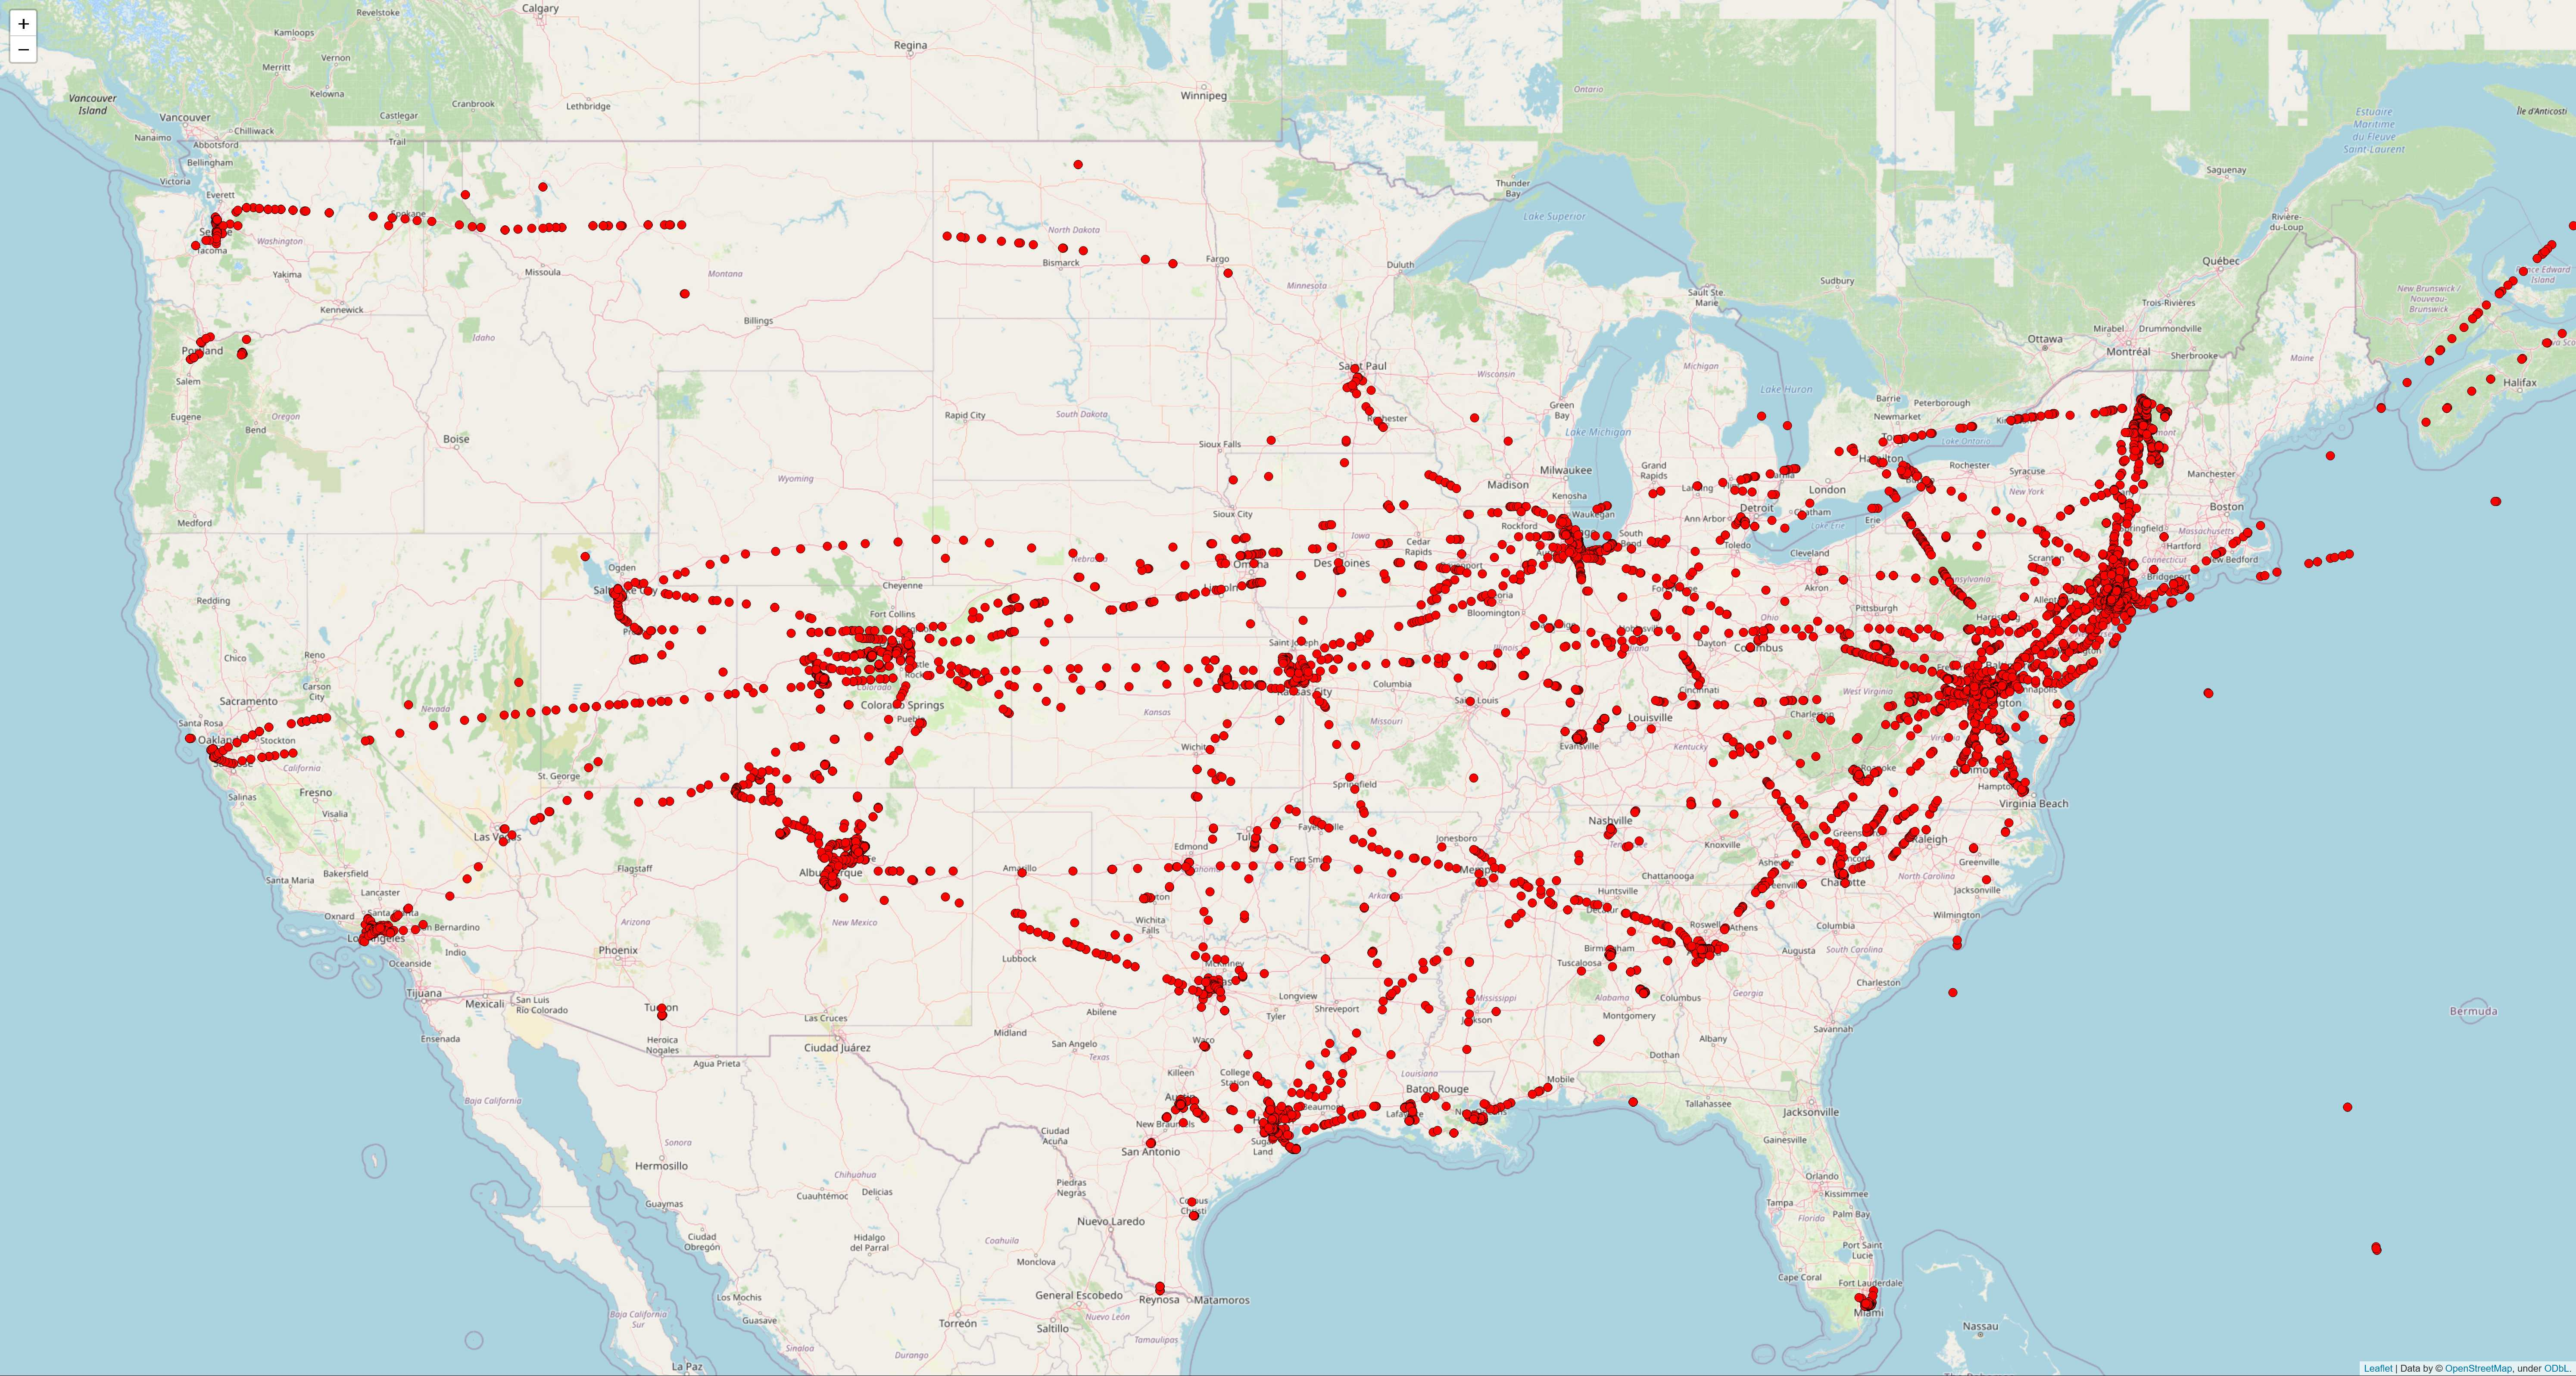

In [15]:
create_map_screenshot(absolute_path_to_map_folder = 
absolute_path_to_map_folder, map_name= 'combined_locations.html', 
screenshot_save_path = screenshot_save_path)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_locations.png', jpg_folder = 'smaller_screenshots', 
reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_locations.jpg'))
# This code is based on DrMcCleod's response at:
# https://stackoverflow.com/a/35061341/13097194

I've traveled around a lot since June 2012 (when I first got my Sony HDR-CX260V camcorder). You can tell from the map that I've spent lots of time in Houston, the DC area, New York, and Chicago, to name a few cities. However, as you'll see later in this notebook, adding paths in between these locations can make it easier to interpret the map.

df_all_locations works fine as a data source for mapping geotags as individual points. However, I wanted to visualize not only points, but also the paths between geotags, which would give me a better sense of where I traveled each year. In order to accurately visualize these paths, I would need to have a DataFrame in which the rows are sorted in chronological order.

Therefore, I created a copy of df_all_locations (df_locations) that excludes entries with a latitude and longitude of 0, since these represented missing geotag data. I might have to update this code if I ever visit [Null Island](https://en.wikipedia.org/wiki/Null_Island)! ;) 

When mapping your own data, you'll need to modify this set of code as needed in order to get your geotags to line up in chronological order. The more devices you've used, the trickier this might be.

In [16]:
df_locations = df_all_locations.query("lat != 0 & lon != 0").copy()
df_locations['modified_time'] = pd.to_datetime(df_locations['modified_time'])
df_locations.reset_index(drop=True,inplace=True)

Next, I'll split my DataFrame into two parts, df_sony_hdrcx260v (which contains Sony HDR-CX260V image data) and df_samsung_galaxy (which contains Samsung Galaxy media data). I took this step because, in order to create a chronologically ordered file list, I needed to sort the Sony HDR-CX260V files by **their file name** and the Samsung Galaxy files by **the time they were modified.** (This discrepancy was likely due to the different ways that both device types handled time zone changes and/or changes that I made to the Sony HDR-CX260V's system time.)

Once these sorts were in place, I could then concatenate the two DataFrames back together. In order to avoid overlapping date ranges (which could interrupt the chronological order of the files in the DataFrame), I only included Samsung Galaxy file entries that occurred after my last Sony HDR-CX260V entry, which was on Christmas Eve 2014. 

In [17]:
df_sony_hdrcx260v = df_locations[df_locations['path'].str.contains(
    'HDRCX260V')].copy().sort_values('name').reset_index(drop=True)
# See:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html
# for information on str.contains. I believe Professor Hardeep Johar gave me
# the idea of using str.contains as a boolean mask to filter a DataFrame.

df_samsung_galaxy = df_locations[df_locations['path'].str.contains(
    'HDRCX260V') == False].copy().sort_values('modified_time').reset_index(
        drop=True)


df_locations = pd.concat([df_sony_hdrcx260v, 
df_samsung_galaxy.query("modified_time > '2015-12-24 13:36'")]) 
# This query limits df_samsung_galaxy to files that were created the minute 
# after my last Sony HDR-CX260V file.

df_locations.query("lat >= @co_min_lat & lat <= @co_max_lat & \
lon >= @co_min_lon & lon <= @co_max_lon")

path                 name  \
1035   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01036.JPG   
1036   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01037.JPG   
1037   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01038.JPG   
1038   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01039.JPG   
1039   H:\D1V1\D1V1\Vids Clips Pics\1 Unsorted Pics\1...         DSC01040.JPG   
...                                                  ...                  ...   
27833  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20230910_123153.mp4   
27834  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20230910_123300.mp4   
27835  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20230910_123315.mp4   
27836  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20230910_123500.mp4   
27837  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20230910_123759.mp4   

                     ctime       modified_time        accessed_time  \
1035   2019-02-23 00:35:51 2012-12-16 21:29:34  2024-01-05 00:35:51   
1036   2019-02-23 00:35:51 2012-12-16 21:29:42  2024-01-05 00:35:51   
1037   2019-02-23 00:35:51 2012-12-16 21:30:02  2024-01-05 00:35:51   
1038   2019-02-23 00:35:51 2012-12-16 21:34:30  2024-01-05 00:35:51   
1039   2019-02-23 00:35:52 2012-12-16 21:34:42  2024-01-05 00:35:51   
...                    ...                 ...                  ...   
27833  2023-09-16 19:58:27 2023-09-10 14:31:57  2024-01-05 01:13:13   
27834  2023-09-16 19:58:27 2023-09-10 14:33:07  2024-01-05 01:13:13   
27835  2023-09-16 19:58:28 2023-09-10 14:33:20  2024-01-05 01:13:13   
27836  2023-09-16 19:58:28 2023-09-10 14:35:06  2024-01-05 01:13:13   
27837  2023-09-16 19:58:29 2023-09-10 14:38:03  2024-01-05 01:13:13   

       megabytes extension  type        raw_location        lat         lon  \
1035    1.815763       jpg   pic                   0  40.541800 -102.062050   
1036    2.493354       jpg   pic                   0  40.538069 -102.082196   
1037    1.746941       jpg   pic                   0  40.528293 -102.135088   
1038    2.071690       jpg   pic                   0  40.520737 -102.175474   
1039    2.009213       jpg   pic                   0  40.520737 -102.175474   
...          ...       ...   ...                 ...        ...         ...   
27833  37.918355       mp4  clip  +39.3380-103.1958/  39.338000 -103.195800   
27834  62.223850       mp4  clip  +39.2867-102.9933/  39.286700 -102.993300   
27835  42.914887       mp4  clip  +39.2750-102.9493/  39.275000 -102.949300   
27836  56.615496       mp4  clip  +39.1948-102.6360/  39.194800 -102.636000   
27837  36.434742       mp4  clip  +39.0539-102.0997/  39.053900 -102.099700   

          alt_capture_time  
1035   2012-12-16 21:29:35  
1036   2012-12-16 21:29:42  
1037   2012-12-16 21:30:03  
1038   2012-12-16 21:34:30  
1039   2012-12-16 21:34:42  
...                    ...  
27833                    x  
27834                    x  
27835                    x  
27836                    x  
27837                    x  

[1478 rows x 12 columns]

The following cell creates a subset of df_locations that shows all the geotags from my Israel trip. It saves this subset to a .csv file so that you can see what the structure of df_locations looks like.

In [18]:
df_locations_israel = df_locations.query(
    "modified_time > '2022-03-11 15:30' & modified_time < '2022-03-18'").copy()

df_locations_israel.to_csv('df_locations_israel.csv',
index = False)

df_locations_israel

path                 name  \
13913  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220311_154524.mp4   
13914  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220311_162615.mp4   
13915  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220311_173221.mp4   
13916  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220311_173333.mp4   
13917  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220311_195916.mp4   
...                                                  ...                  ...   
14408  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055014.mp4   
14409  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055031.mp4   
14410  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055053.mp4   
14411  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055118.mp4   
14412  H:\D2V1\Vids Clips Pics\2 Unsorted Clips\34 Ga...  20220318_055138.mp4   

                     ctime       modified_time        accessed_time  \
13913  2022-03-18 17:27:58 2022-03-11 15:45:28  2024-01-05 01:22:05   
13914  2022-03-18 17:27:44 2022-03-11 16:26:20  2024-01-05 01:22:06   
13915  2022-03-18 17:27:58 2022-03-11 17:32:28  2024-01-05 01:22:06   
13916  2022-03-18 17:27:59 2022-03-11 17:33:42  2024-01-05 01:22:06   
13917  2022-03-18 17:28:00 2022-03-11 19:59:25  2024-01-05 01:22:06   
...                    ...                 ...                  ...   
14408  2022-03-18 17:35:11 2022-03-17 23:50:22  2024-01-05 01:23:08   
14409  2022-03-18 17:35:12 2022-03-17 23:50:45  2024-01-05 01:23:08   
14410  2022-03-18 17:35:13 2022-03-17 23:51:02  2024-01-05 01:23:08   
14411  2022-03-18 17:35:14 2022-03-17 23:51:24  2024-01-05 01:23:08   
14412  2022-03-18 17:35:14 2022-03-17 23:51:46  2024-01-05 01:23:08   

        megabytes extension  type        raw_location      lat      lon  \
13913   36.069064       mp4  clip  +32.0031+034.8724/  32.0031  34.8724   
13914   39.682264       mp4  clip  +32.0008+034.8705/  32.0008  34.8705   
13915   53.524944       mp4  clip  +32.0796+034.7678/  32.0796  34.7678   
13916   84.044346       mp4  clip  +32.0794+034.7678/  32.0794  34.7678   
13917   69.771367       mp4  clip  +32.0794+034.7674/  32.0794  34.7674   
...           ...       ...   ...                 ...      ...      ...   
14408   80.279707       mp4  clip  +32.0128+034.8600/  32.0128  34.8600   
14409  125.635733       mp4  clip  +32.0023+034.8102/  32.0023  34.8102   
14410   77.499335       mp4  clip  +32.0023+034.8102/  32.0023  34.8102   
14411   55.145896       mp4  clip  +32.0023+034.8102/  32.0023  34.8102   
14412   64.585904       mp4  clip  +31.9967+034.7366/  31.9967  34.7366   

      alt_capture_time  
13913                x  
13914                x  
13915                x  
13916                x  
13917                x  
...                ...  
14408                x  
14409                x  
14410                x  
14411                x  
14412                x  

[500 rows x 12 columns]

Now that I have my sorted DataFrame, I can begin creating maps that show path information.

I'll first show two small-scale examples with fewer than 500 points. First, I'll show a map of a trip to Israel that I went on in March 2022 (using the df_locations_israel DataFrame):

In [19]:
df_locations_israel = pd.read_csv('df_locations_israel.csv')
israel_trip_map = map_media_locations(df_locations_israel, 
    folder_path = 'maps', file_name = '2022_03_Israel_trip', 
    starting_location = [32, 35], zoom_start = 9, add_paths = True)
israel_trip_map

Added 500 markers to the map.


Note that hovering over a given point brings up a tooltip with both the file's modified date and the geotags (geographic coordiates) of that file. If you *click* on a point, you'll be able to see the original file name.

The map is zoomed in in order to compensate for how my screenshot generation code works, so feel free to zoom out and pan the map around. For instance, if you zoom into Jerusalem, you can see the path of my journeys around the Old City.

Next, I'll create a similar map showing a trip to Miami that I went on the following month. (The MBA allows for lots of travel, especially during your final semester!) I'll change some of the aesthetic arguments passed to map_media_locations for demonstration purposes.

In [20]:
miami_trip_map = map_media_locations(df_locations.query(
    "modified_time > '2022-04-08 15:00' & modified_time < '2022-04-11 11:30'"), 
    folder_path = 'maps', file_name = '2022_04_Miami_trip', 
    starting_location = [25.77, -80.2], 
zoom_start = 14, add_paths = True,
circle_marker_color='#00ff00', radius = 8, tiles = 'OpenStreetMap',
path_color = 'orange', path_weight = 2)
miami_trip_map

Added 209 markers to the map.


You'll get a better view of the map if you zoom out a little bit. (As with the Israel map, it's zoomed in to compensate for how my screenshot generation code works.)

Next, I'll create maps showing all 23,000+ geotags in df_locations, along with paths connecting these points. One map will be zoomed in to focus on the US, whereas the other map will be zoomed out to show a global view.

In [21]:
map_media_locations(df_locations, folder_path = 'maps', 
file_name = 'combined_routes', add_paths = True, zoom_start = 6)

map_media_locations(df_locations, folder_path = 'maps', 
file_name = 'combined_routes_intl', add_paths = True, zoom_start = 3)
print("Done")

Added 38844 markers to the map.
Added 38844 markers to the map.
Done


Here's a look at the domestic version of the map:

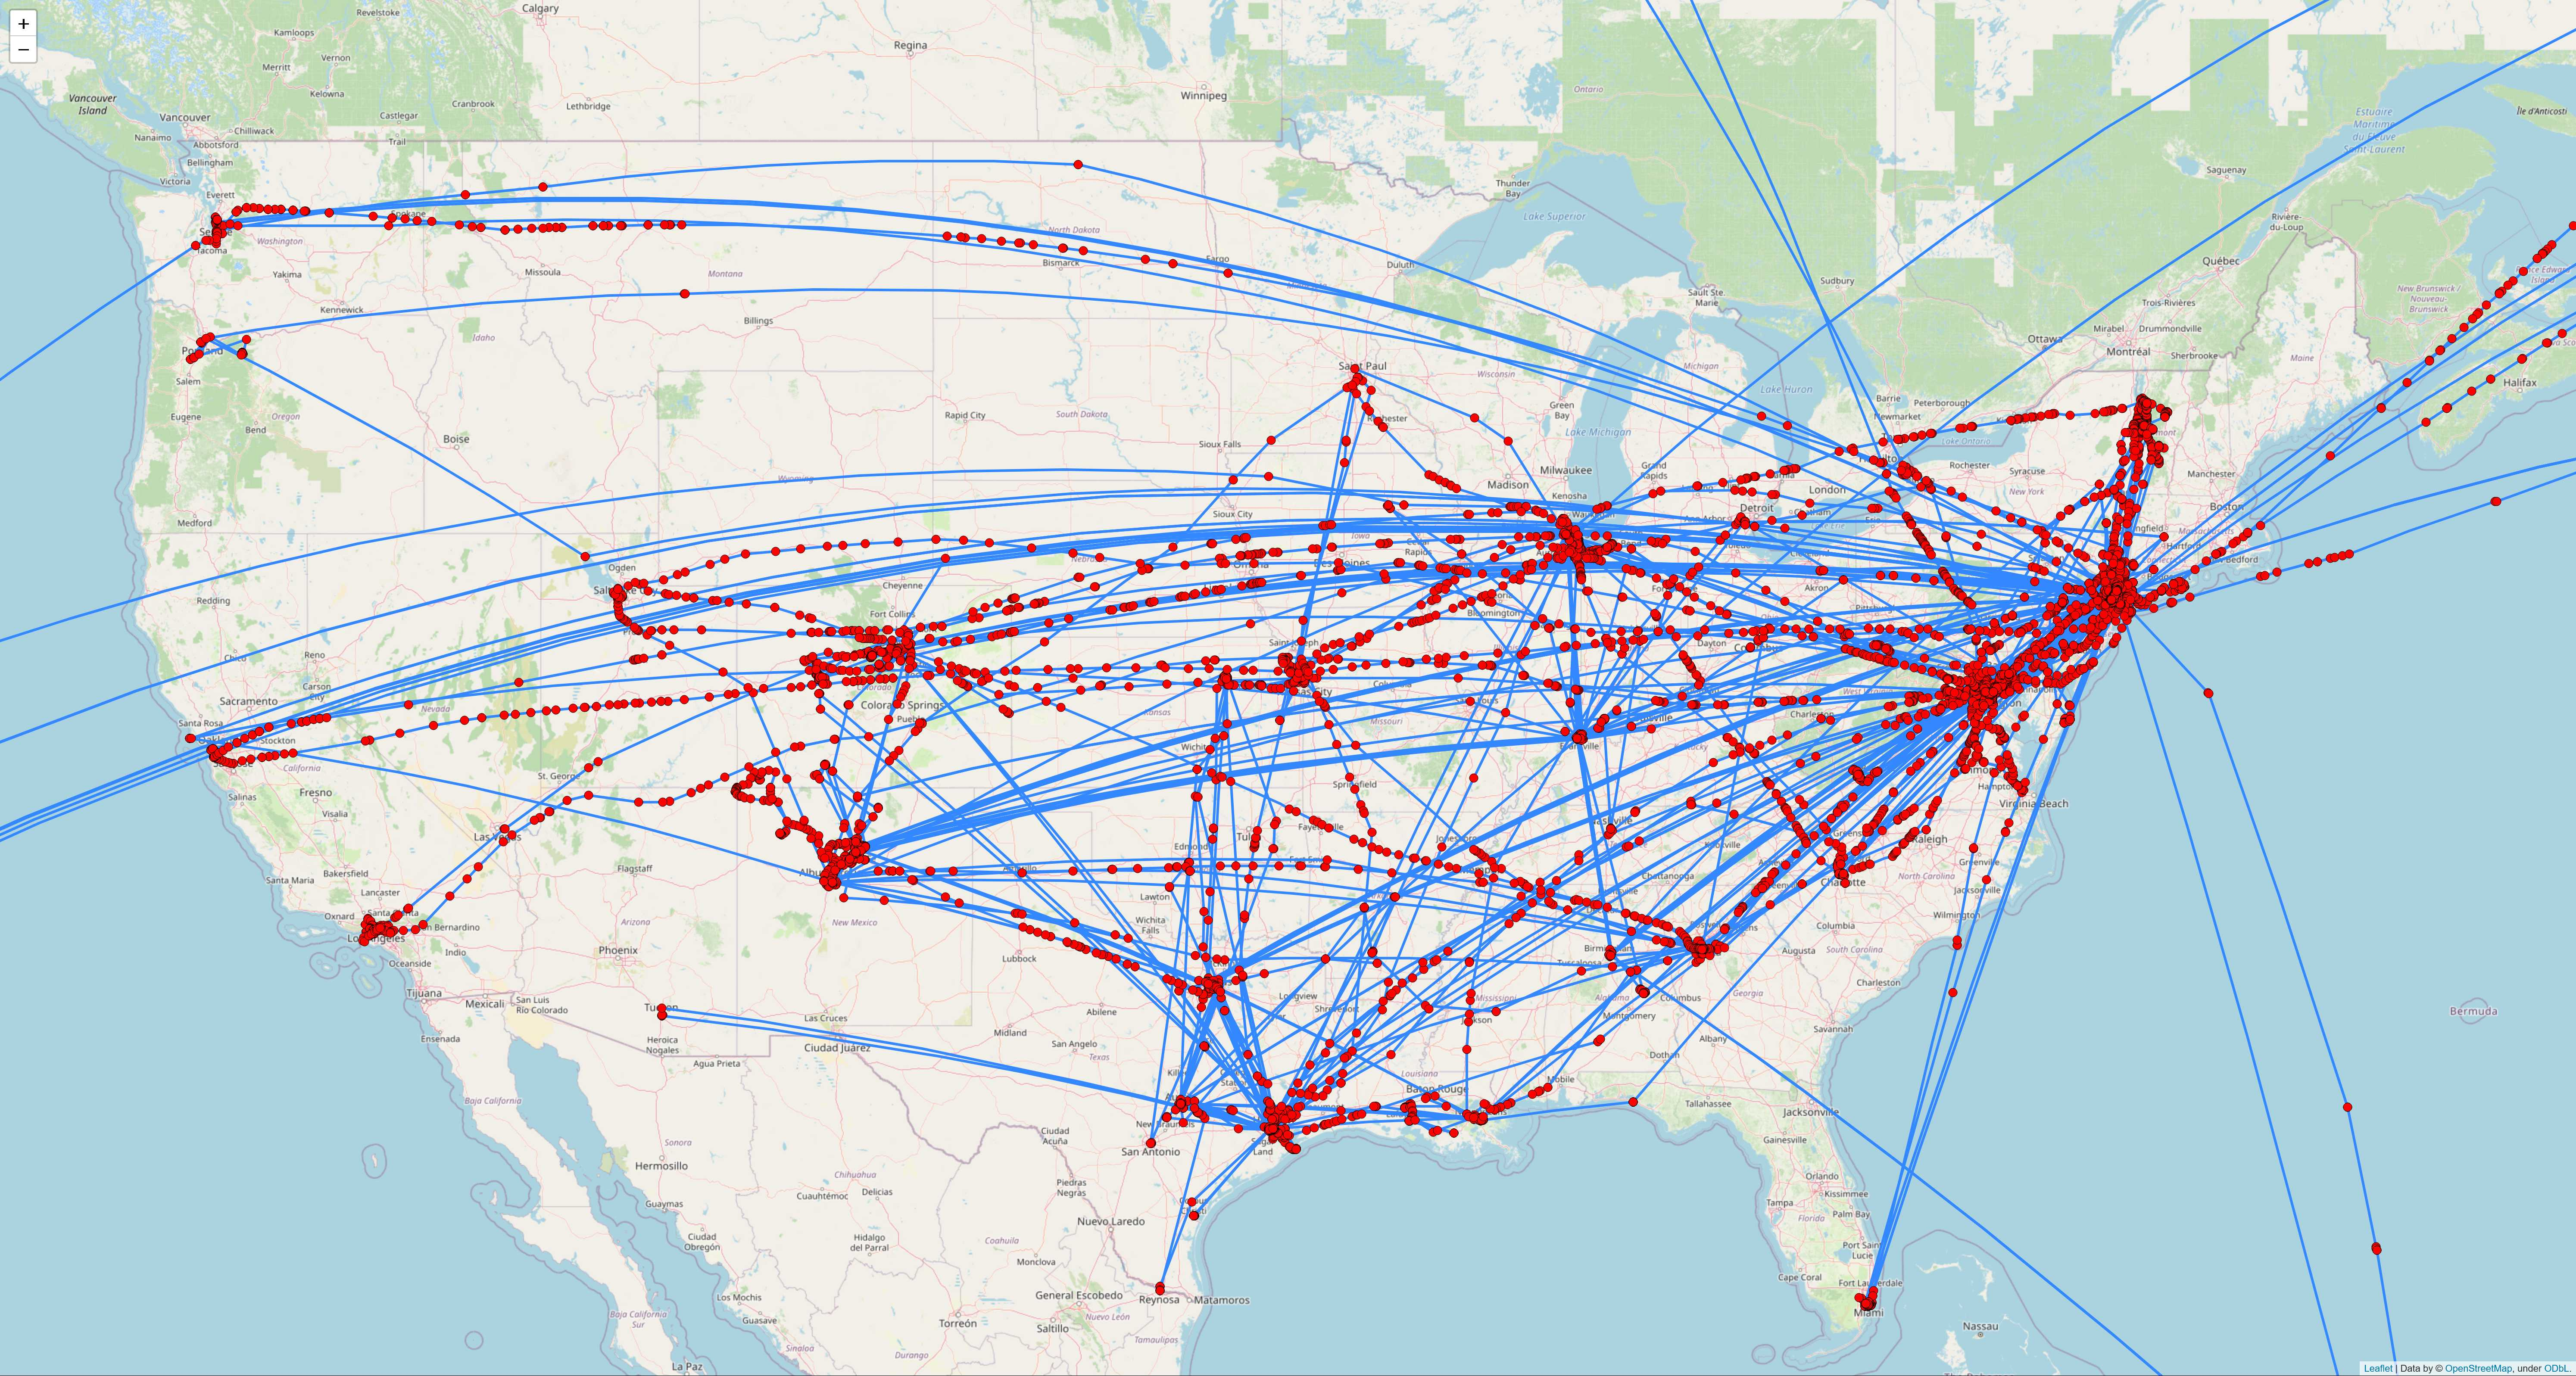

In [22]:
create_map_screenshot(absolute_path_to_map_folder = absolute_path_to_map_folder,
map_name= 'combined_routes_locations.html', 
screenshot_save_path = screenshot_save_path)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_routes_locations.png', 
jpg_folder = 'smaller_screenshots', reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_routes_locations.jpg'))

This map is admittedly hard to read, given that it plots tens of thousands of points and their corresponding paths, but it does show both places where I've been and what my journey in between those places has looked like. For instance, it's clear that I traveled from New York to Miami and from Texas to Arizona. Later in this notebook, I'll create individual maps for each year, which will provide a clearer picture of where I've traveled (and lived) over time.

Here's a look at the global version of the above map:

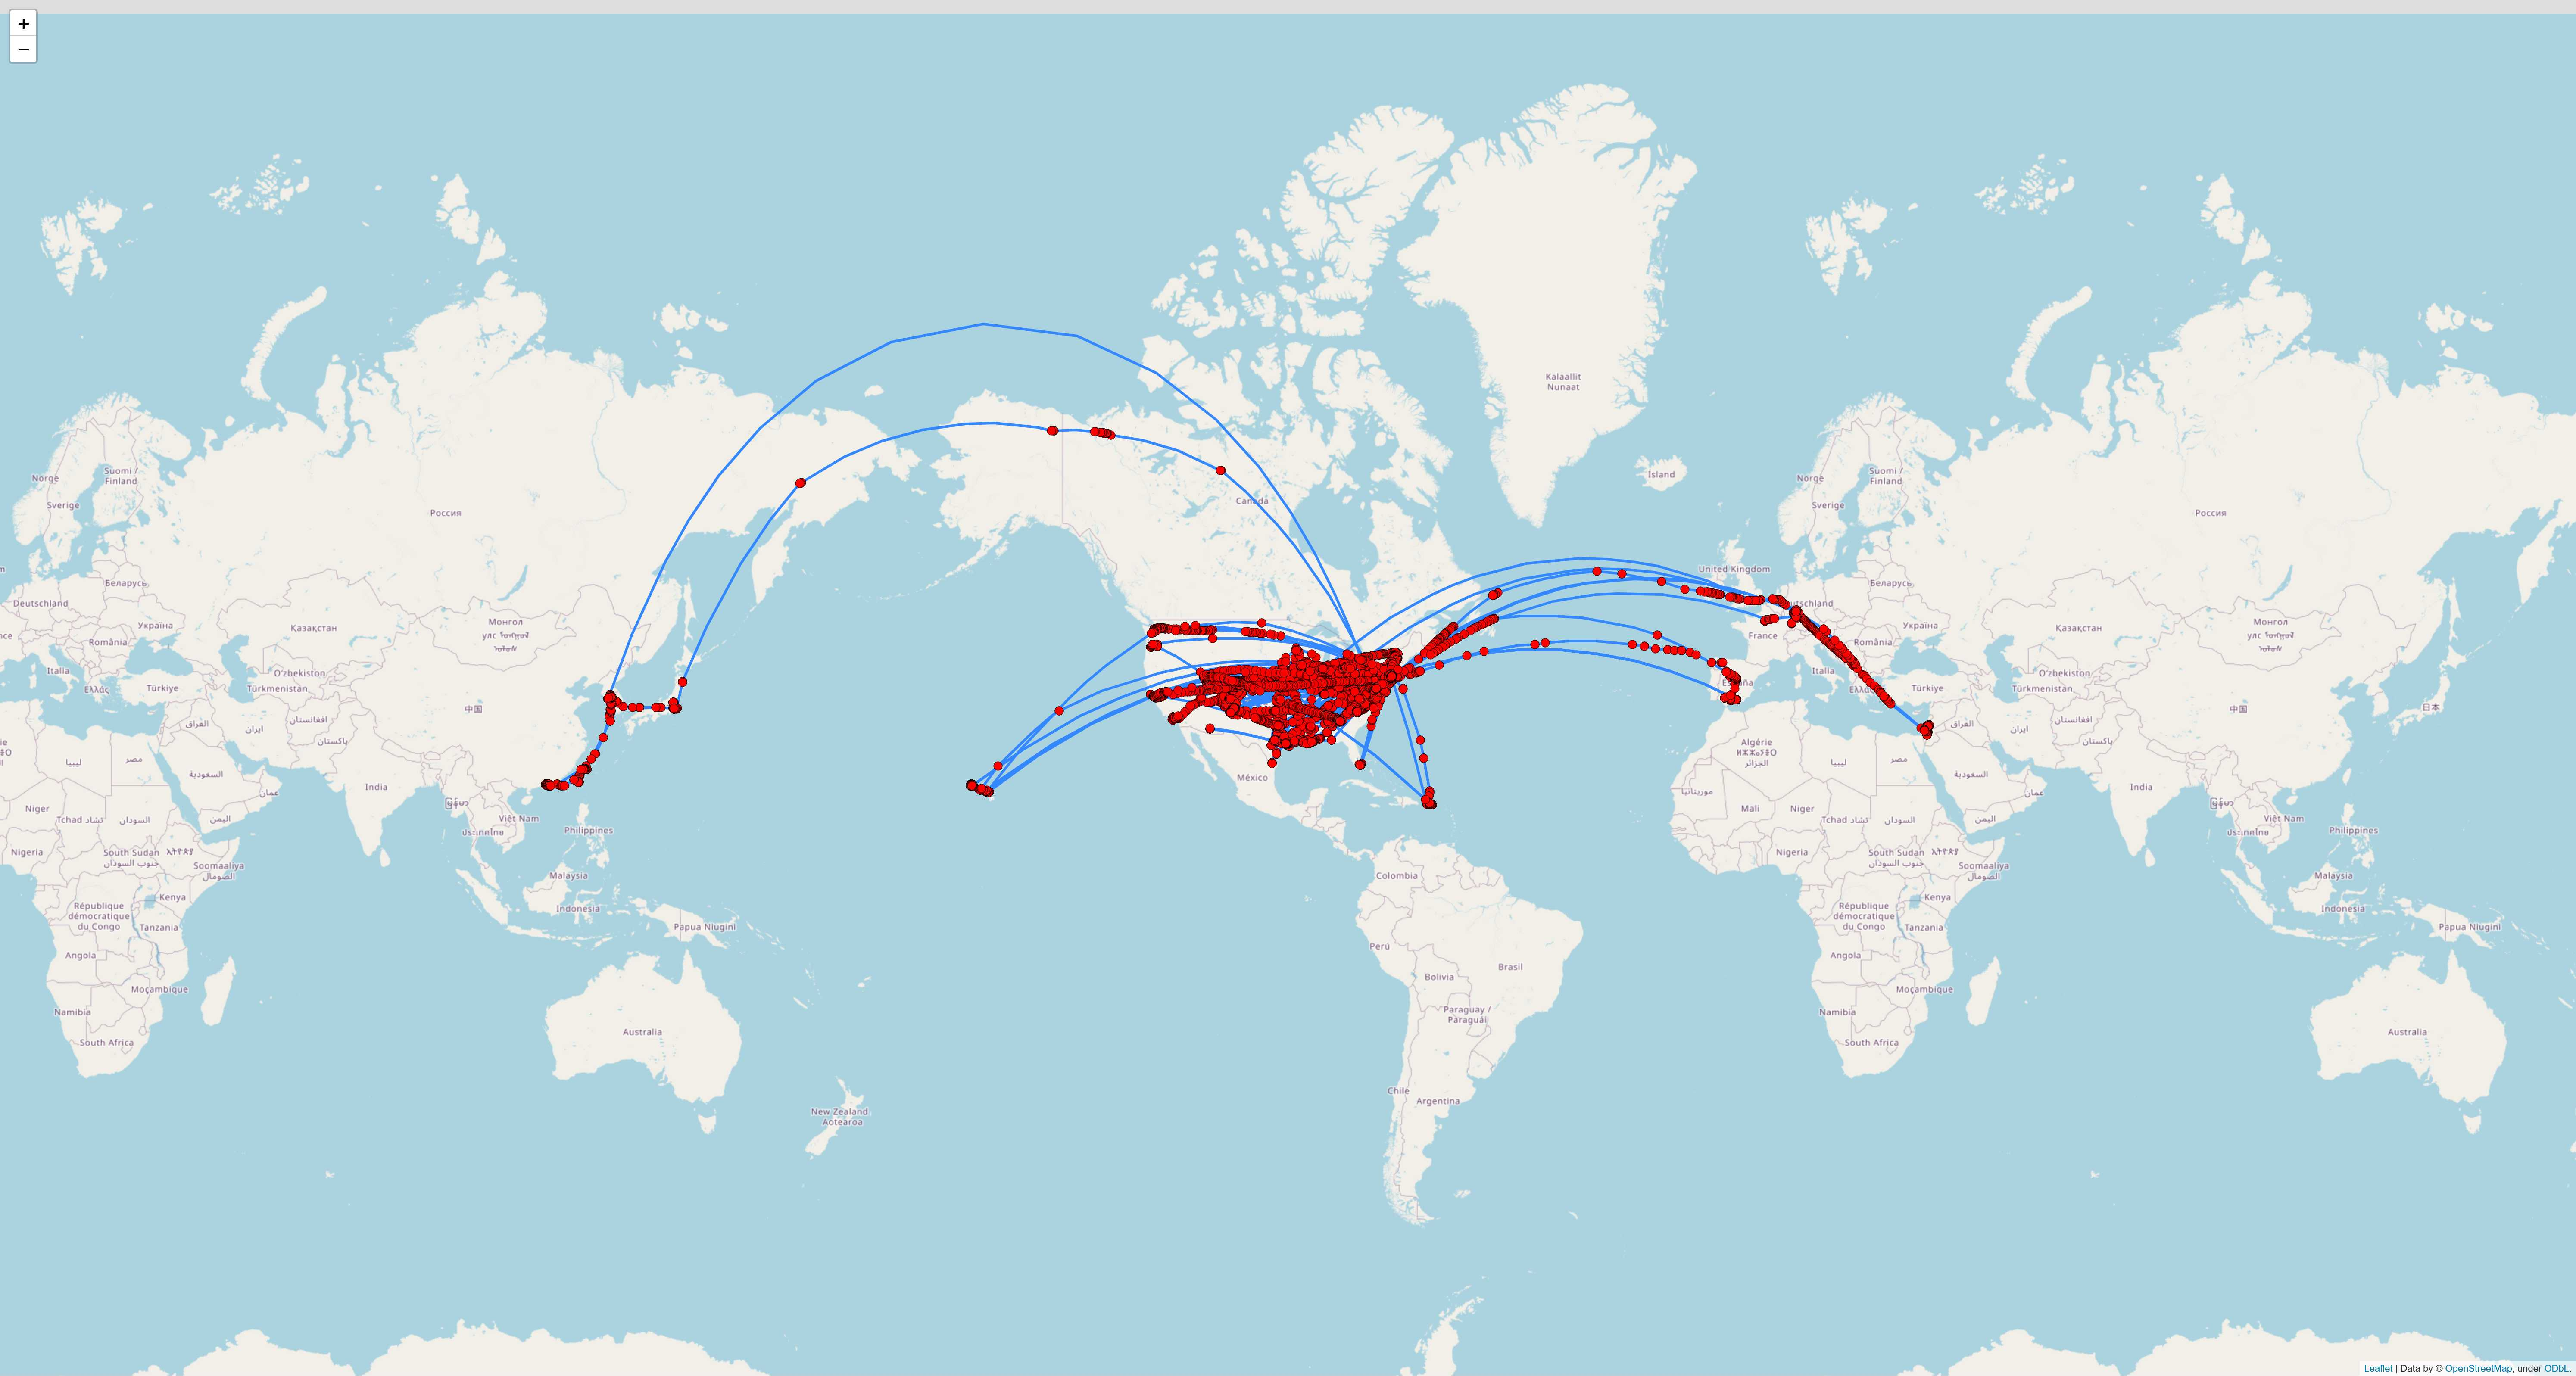

In [23]:
create_map_screenshot(absolute_path_to_map_folder = absolute_path_to_map_folder,
map_name= 'combined_routes_intl_locations.html', 
screenshot_save_path = screenshot_save_path)

convert_png_to_smaller_jpg(png_folder = 'map_screenshots', 
png_image_name = 'combined_routes_intl_locations.png', 
jpg_folder = 'smaller_screenshots', reduction_factor = 1, quality_factor = 50)

IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'combined_routes_intl_locations.jpg'))

To make it easier to see how my travel (and places of residence) changed over time, I'll next create maps showing the geotags and paths for each year.

In [24]:
international_travel_years = [2013, 2018, 2022, 2023] 
# These are the years in df_locations with international geotags.

In [25]:
map_dict = {}
for i in range(2012, datetime.date.today().year+1):
    print(f"Creating map for {i}:")
    next_year = i+1
    map_dict[i] = map_media_locations(df_locations.query(
        "modified_time >= @i & modified_time < @next_year"),
        folder_path = 'maps', file_name = f'{i}_combined', 
        add_paths = True, zoom_start = 6)
    if i in international_travel_years:
        map_media_locations(df_locations.query(
            "modified_time >= @i & modified_time < @next_year"),
            folder_path = 'maps', file_name = f'{i}_combined_intl',
            add_paths = True, zoom_start = 3)

Creating map for 2012:
Added 1447 markers to the map.
Creating map for 2013:
Added 4199 markers to the map.
Added 4199 markers to the map.
Creating map for 2014:
Added 1729 markers to the map.
Creating map for 2015:
Added 925 markers to the map.
Creating map for 2016:
Added 2906 markers to the map.
Creating map for 2017:
Added 251 markers to the map.
Creating map for 2018:
Added 363 markers to the map.
Added 363 markers to the map.
Creating map for 2019:
Added 310 markers to the map.
Creating map for 2020:
Added 2251 markers to the map.
Creating map for 2021:
Added 6015 markers to the map.
Creating map for 2022:
Added 10471 markers to the map.
Added 10471 markers to the map.
Creating map for 2023:
Added 6517 markers to the map.
Added 6517 markers to the map.
Creating map for 2024:
Added 1460 markers to the map.


I now have .html versions of these maps, but to make them easier to share, I'll now create .png screenshots of these maps, then convert those .png screenshots to smaller .jpg files. I'll display the output of these screenshots later in this notebook.

In [26]:
batch_create_map_screenshots(absolute_path_to_map_folder = 
absolute_path_to_map_folder, screenshot_save_path = 
screenshot_save_path)

In [27]:
batch_convert_pngs_to_smaller_jpgs(png_folder = 'map_screenshots', 
    jpg_folder = 'smaller_screenshots', reduction_factor = 1, 
    quality_factor = 50) 

Here are the smaller .jpg versions of my map screenshots, some of which I'll display below:

In [28]:
for root, dirs, files in os.walk('smaller_screenshots'):
    smaller_screenshot_list = files

smaller_screenshot_list

['2012_combined_locations.jpg',
 '2013_combined_intl_locations.jpg',
 '2013_combined_locations.jpg',
 '2014_combined_locations.jpg',
 '2015_combined_locations.jpg',
 '2016_combined_locations.jpg',
 '2017_combined_locations.jpg',
 '2018_combined_intl_locations.jpg',
 '2018_combined_locations.jpg',
 '2019_combined_locations.jpg',
 '2020_combined_locations.jpg',
 '2021_combined_locations.jpg',
 '2022_03_Israel_trip_locations.jpg',
 '2022_04_Miami_trip_locations.jpg',
 '2022_combined_intl_locations.jpg',
 '2022_combined_locations.jpg',
 '2023_combined_intl_locations.jpg',
 '2023_combined_locations.jpg',
 '2024_combined_locations.jpg',
 'combined_locations.jpg',
 'combined_routes_intl_locations.jpg',
 'combined_routes_locations.jpg']

In 2012, I spent lots of time in Vermont and Virginia:

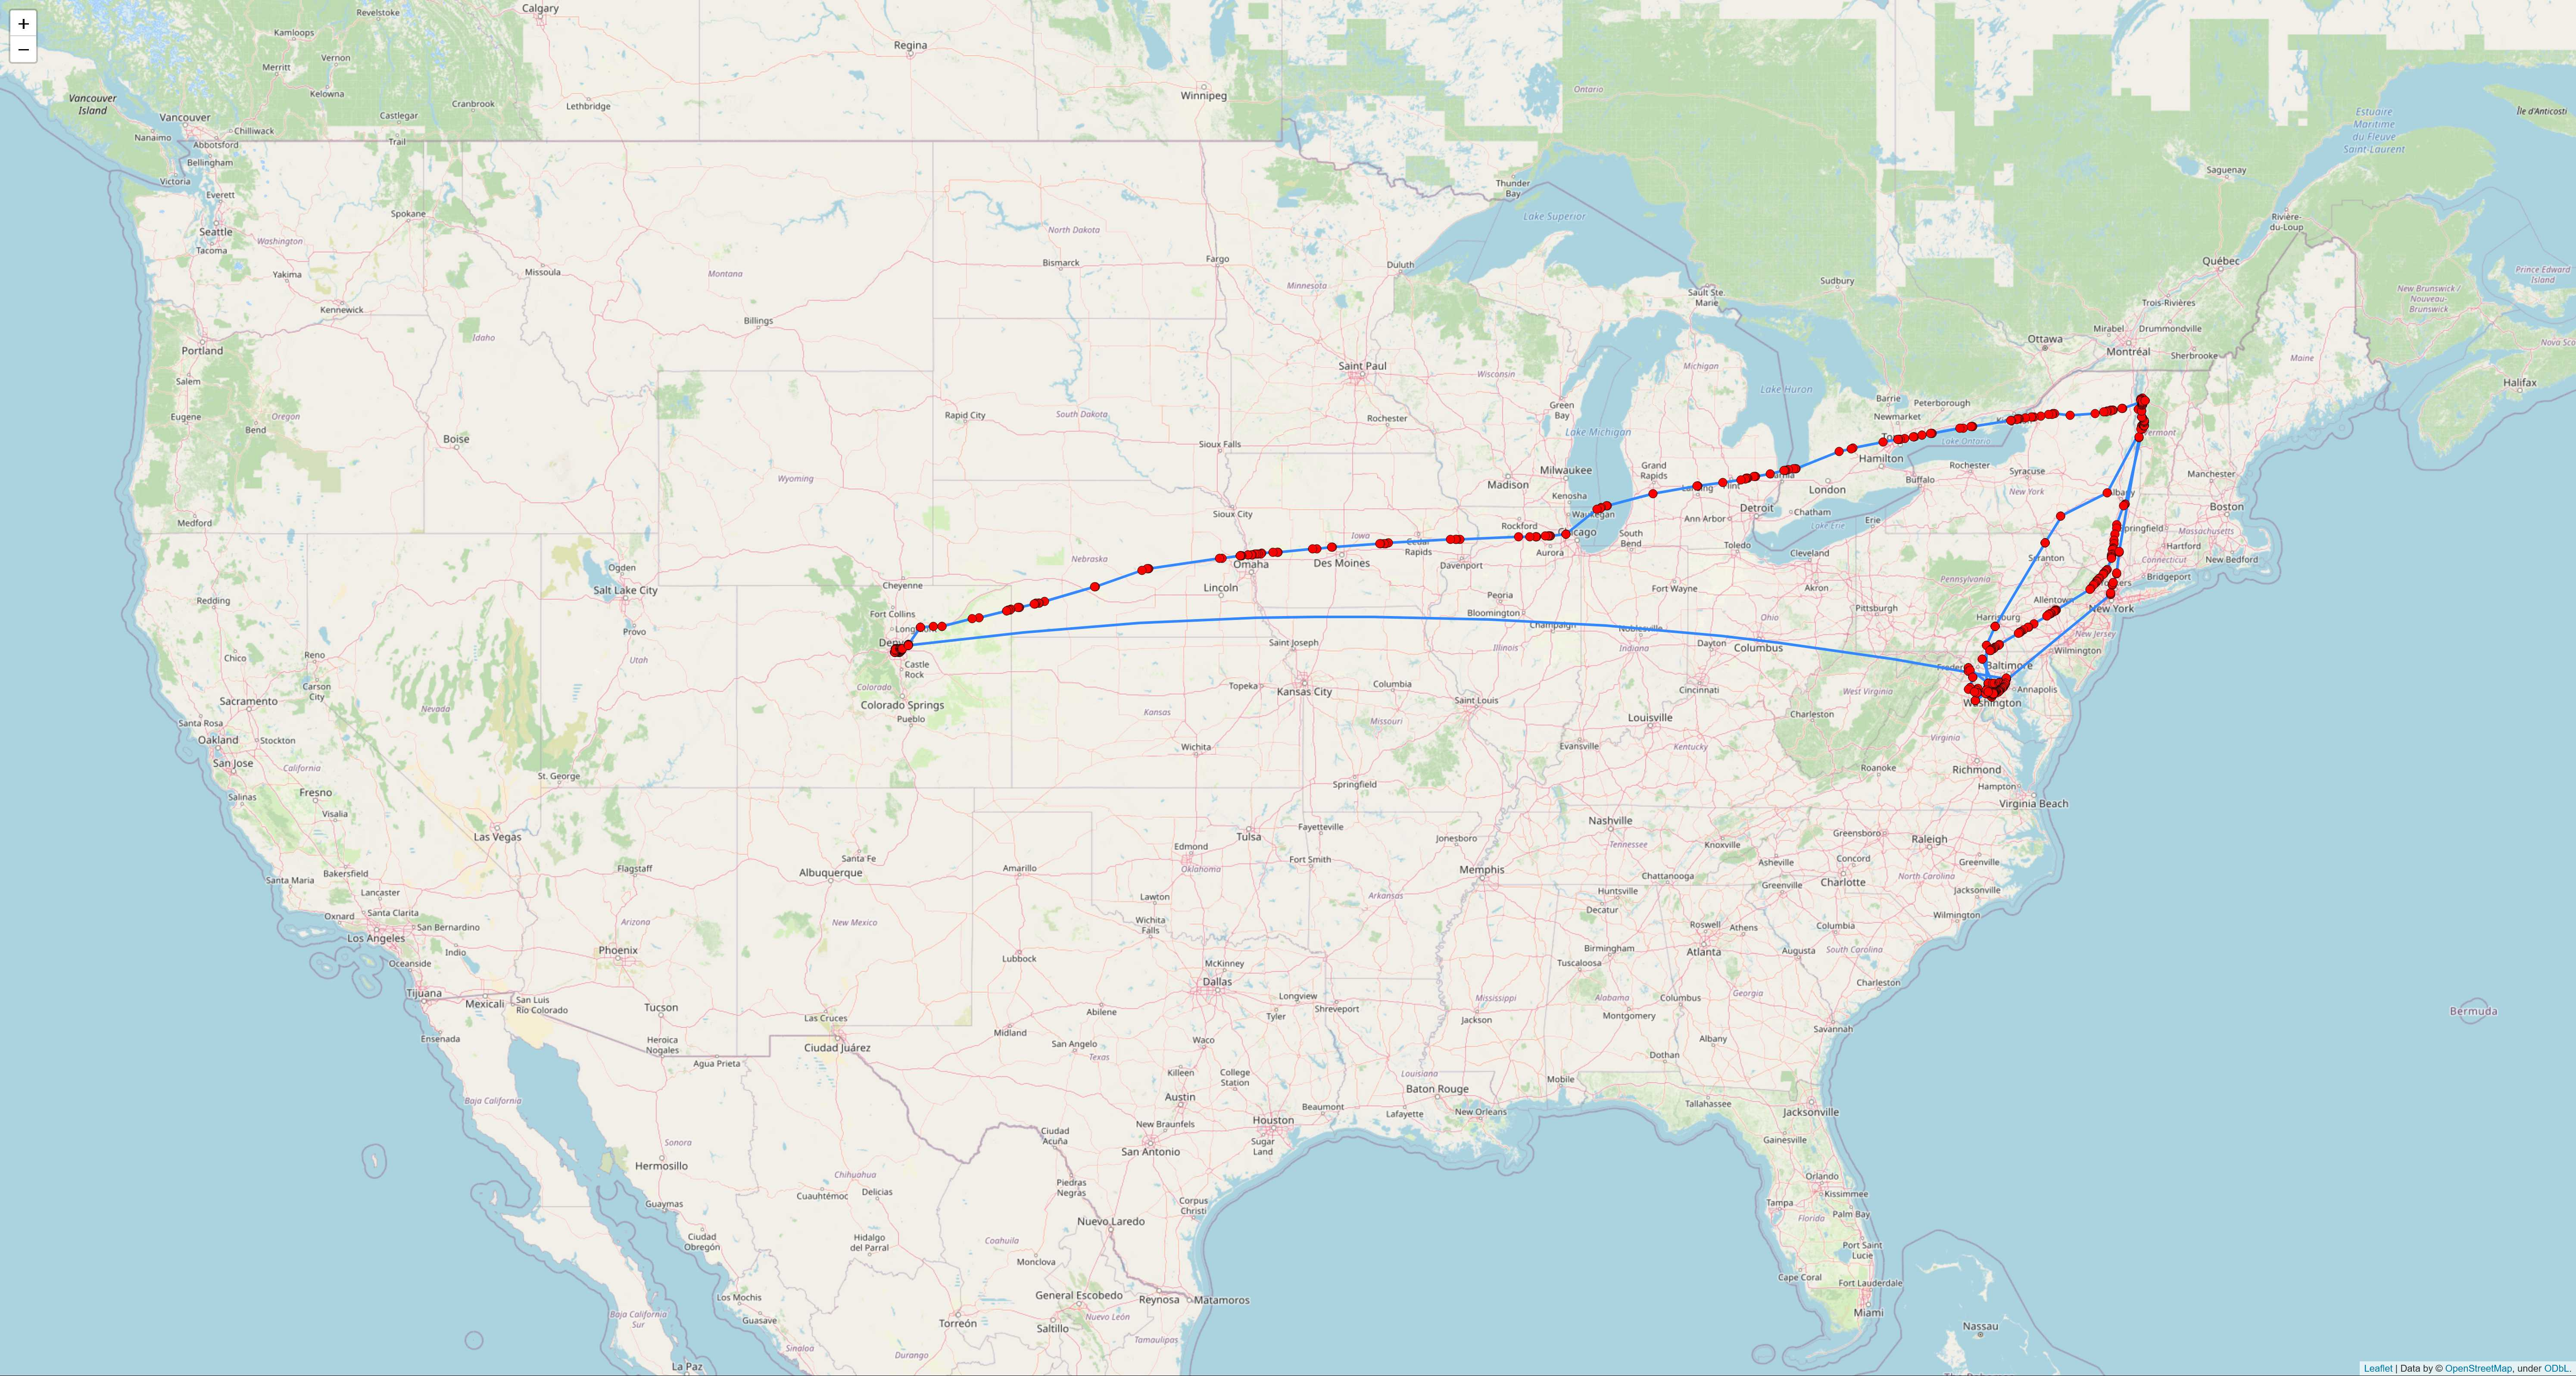

In [29]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2012_combined_locations.jpg'))

Meanwhile, in 2015, many of my trips originated from Houston:

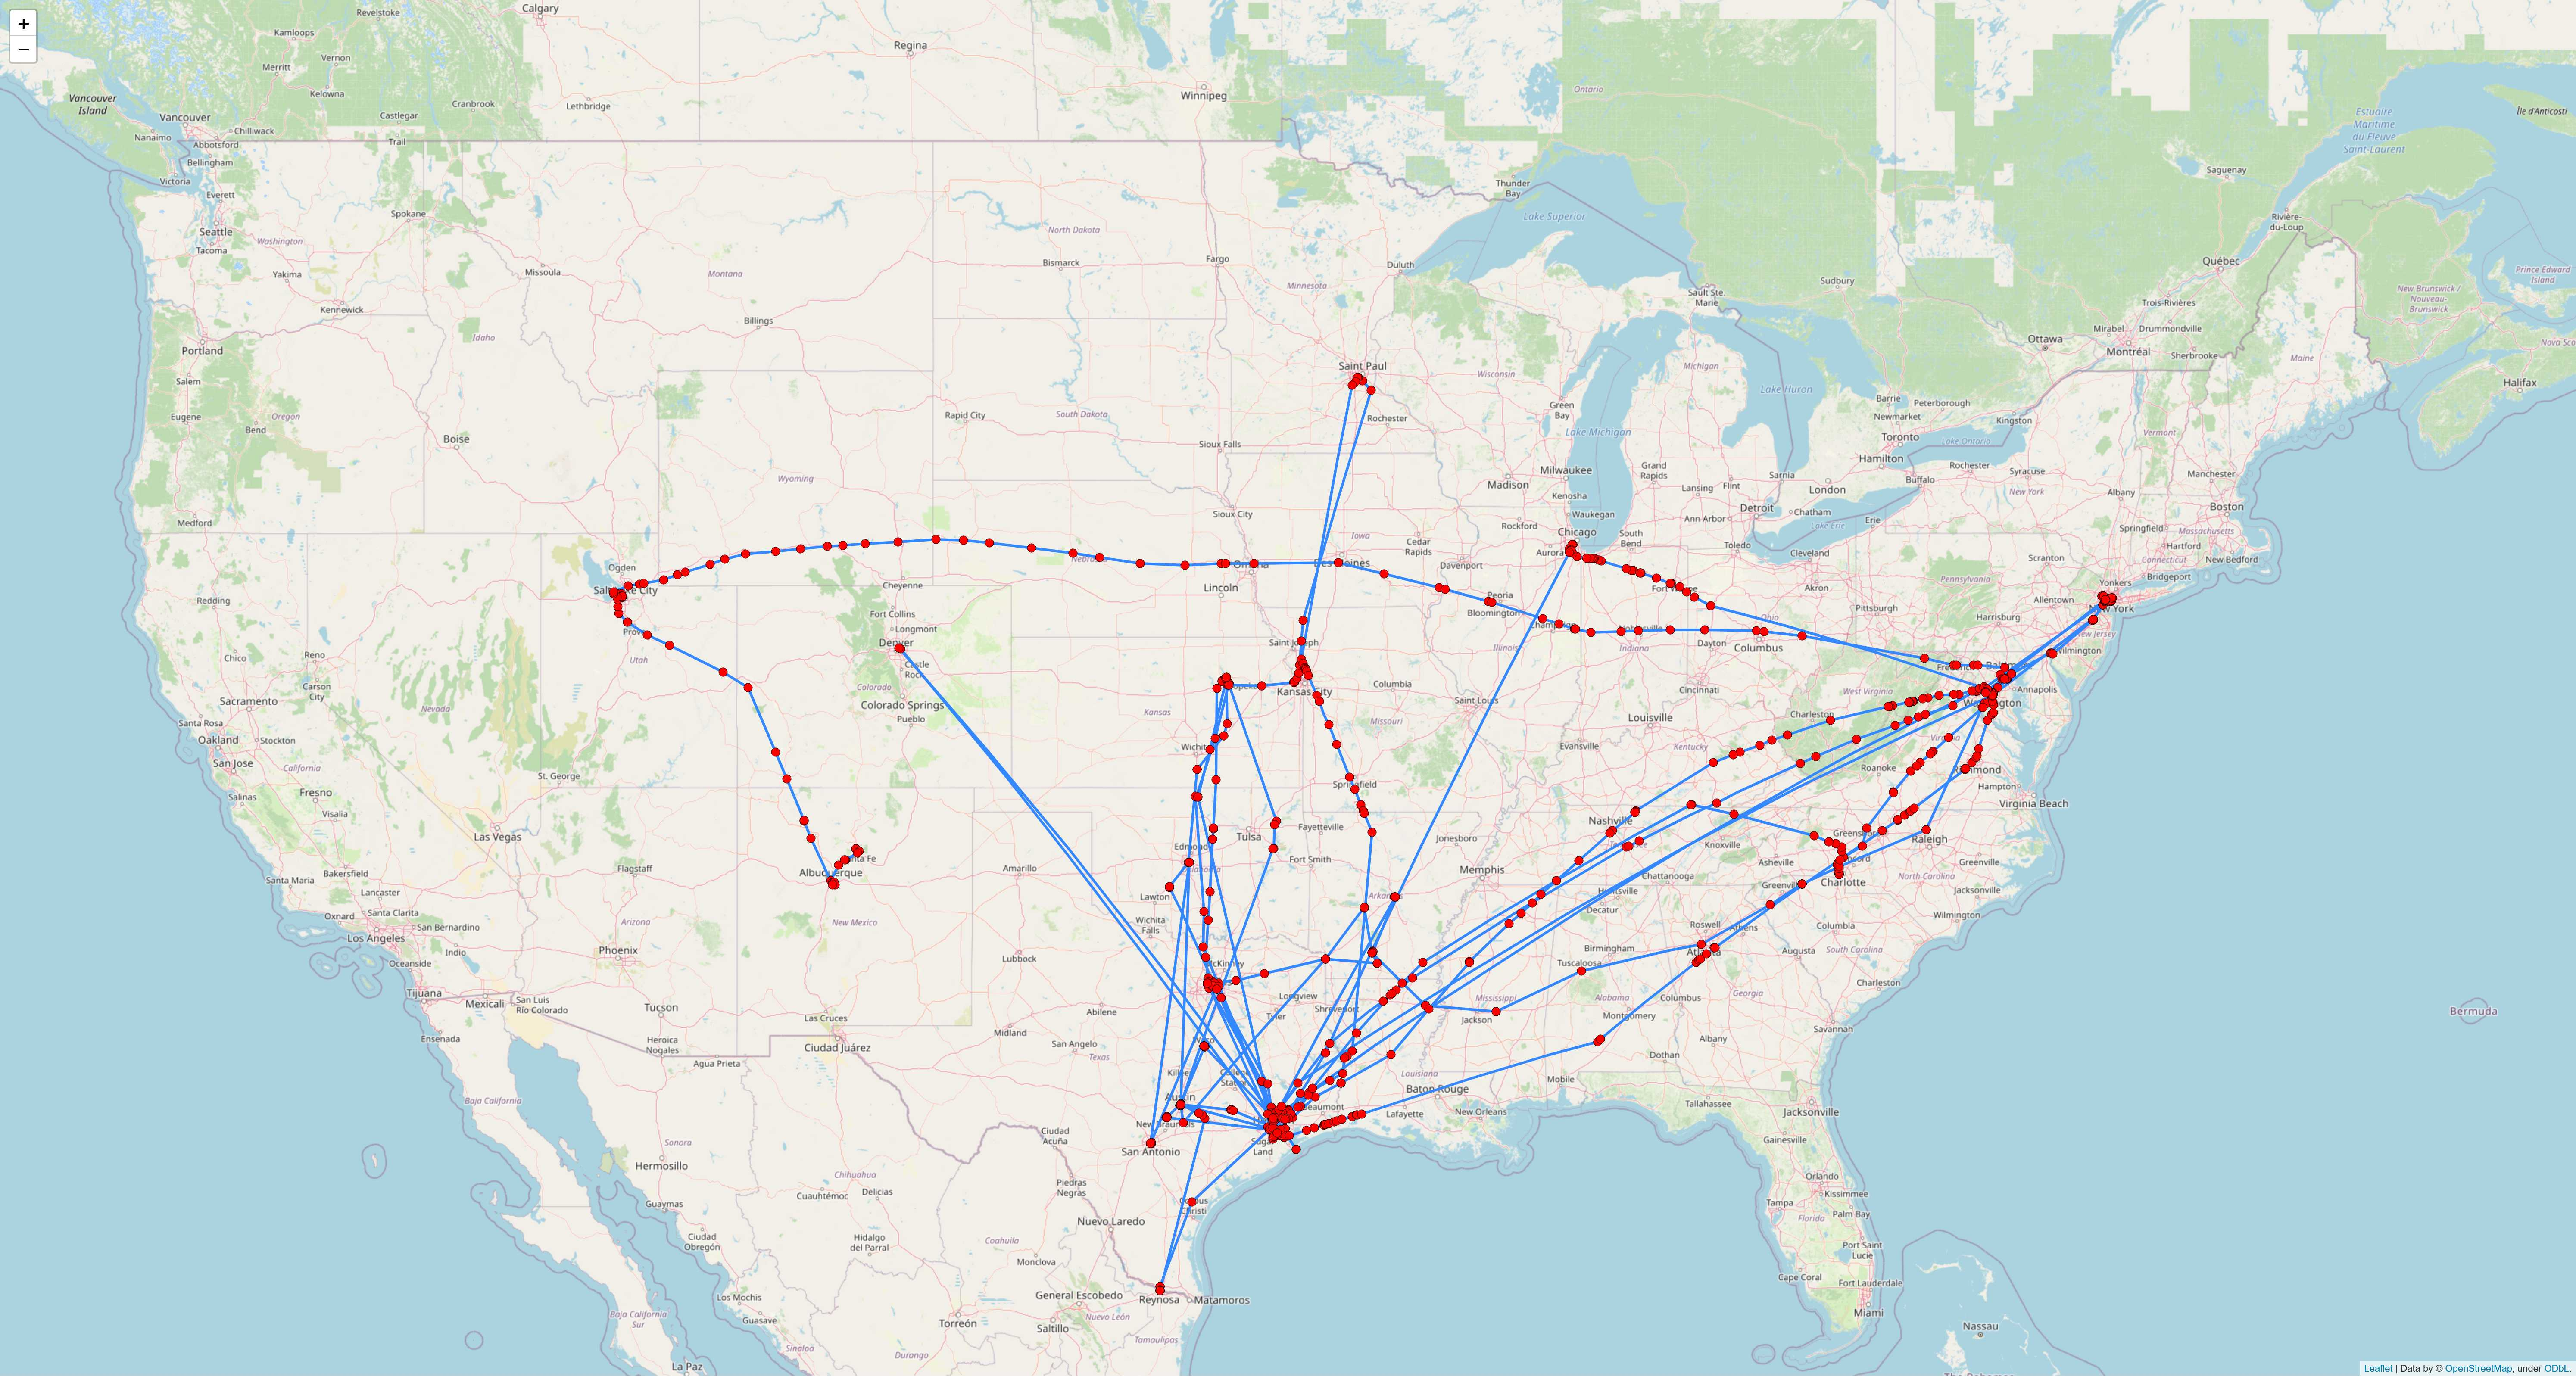

In [30]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2015_combined_locations.jpg'))

And in 2022, most of my travels were focused on the East Coast:

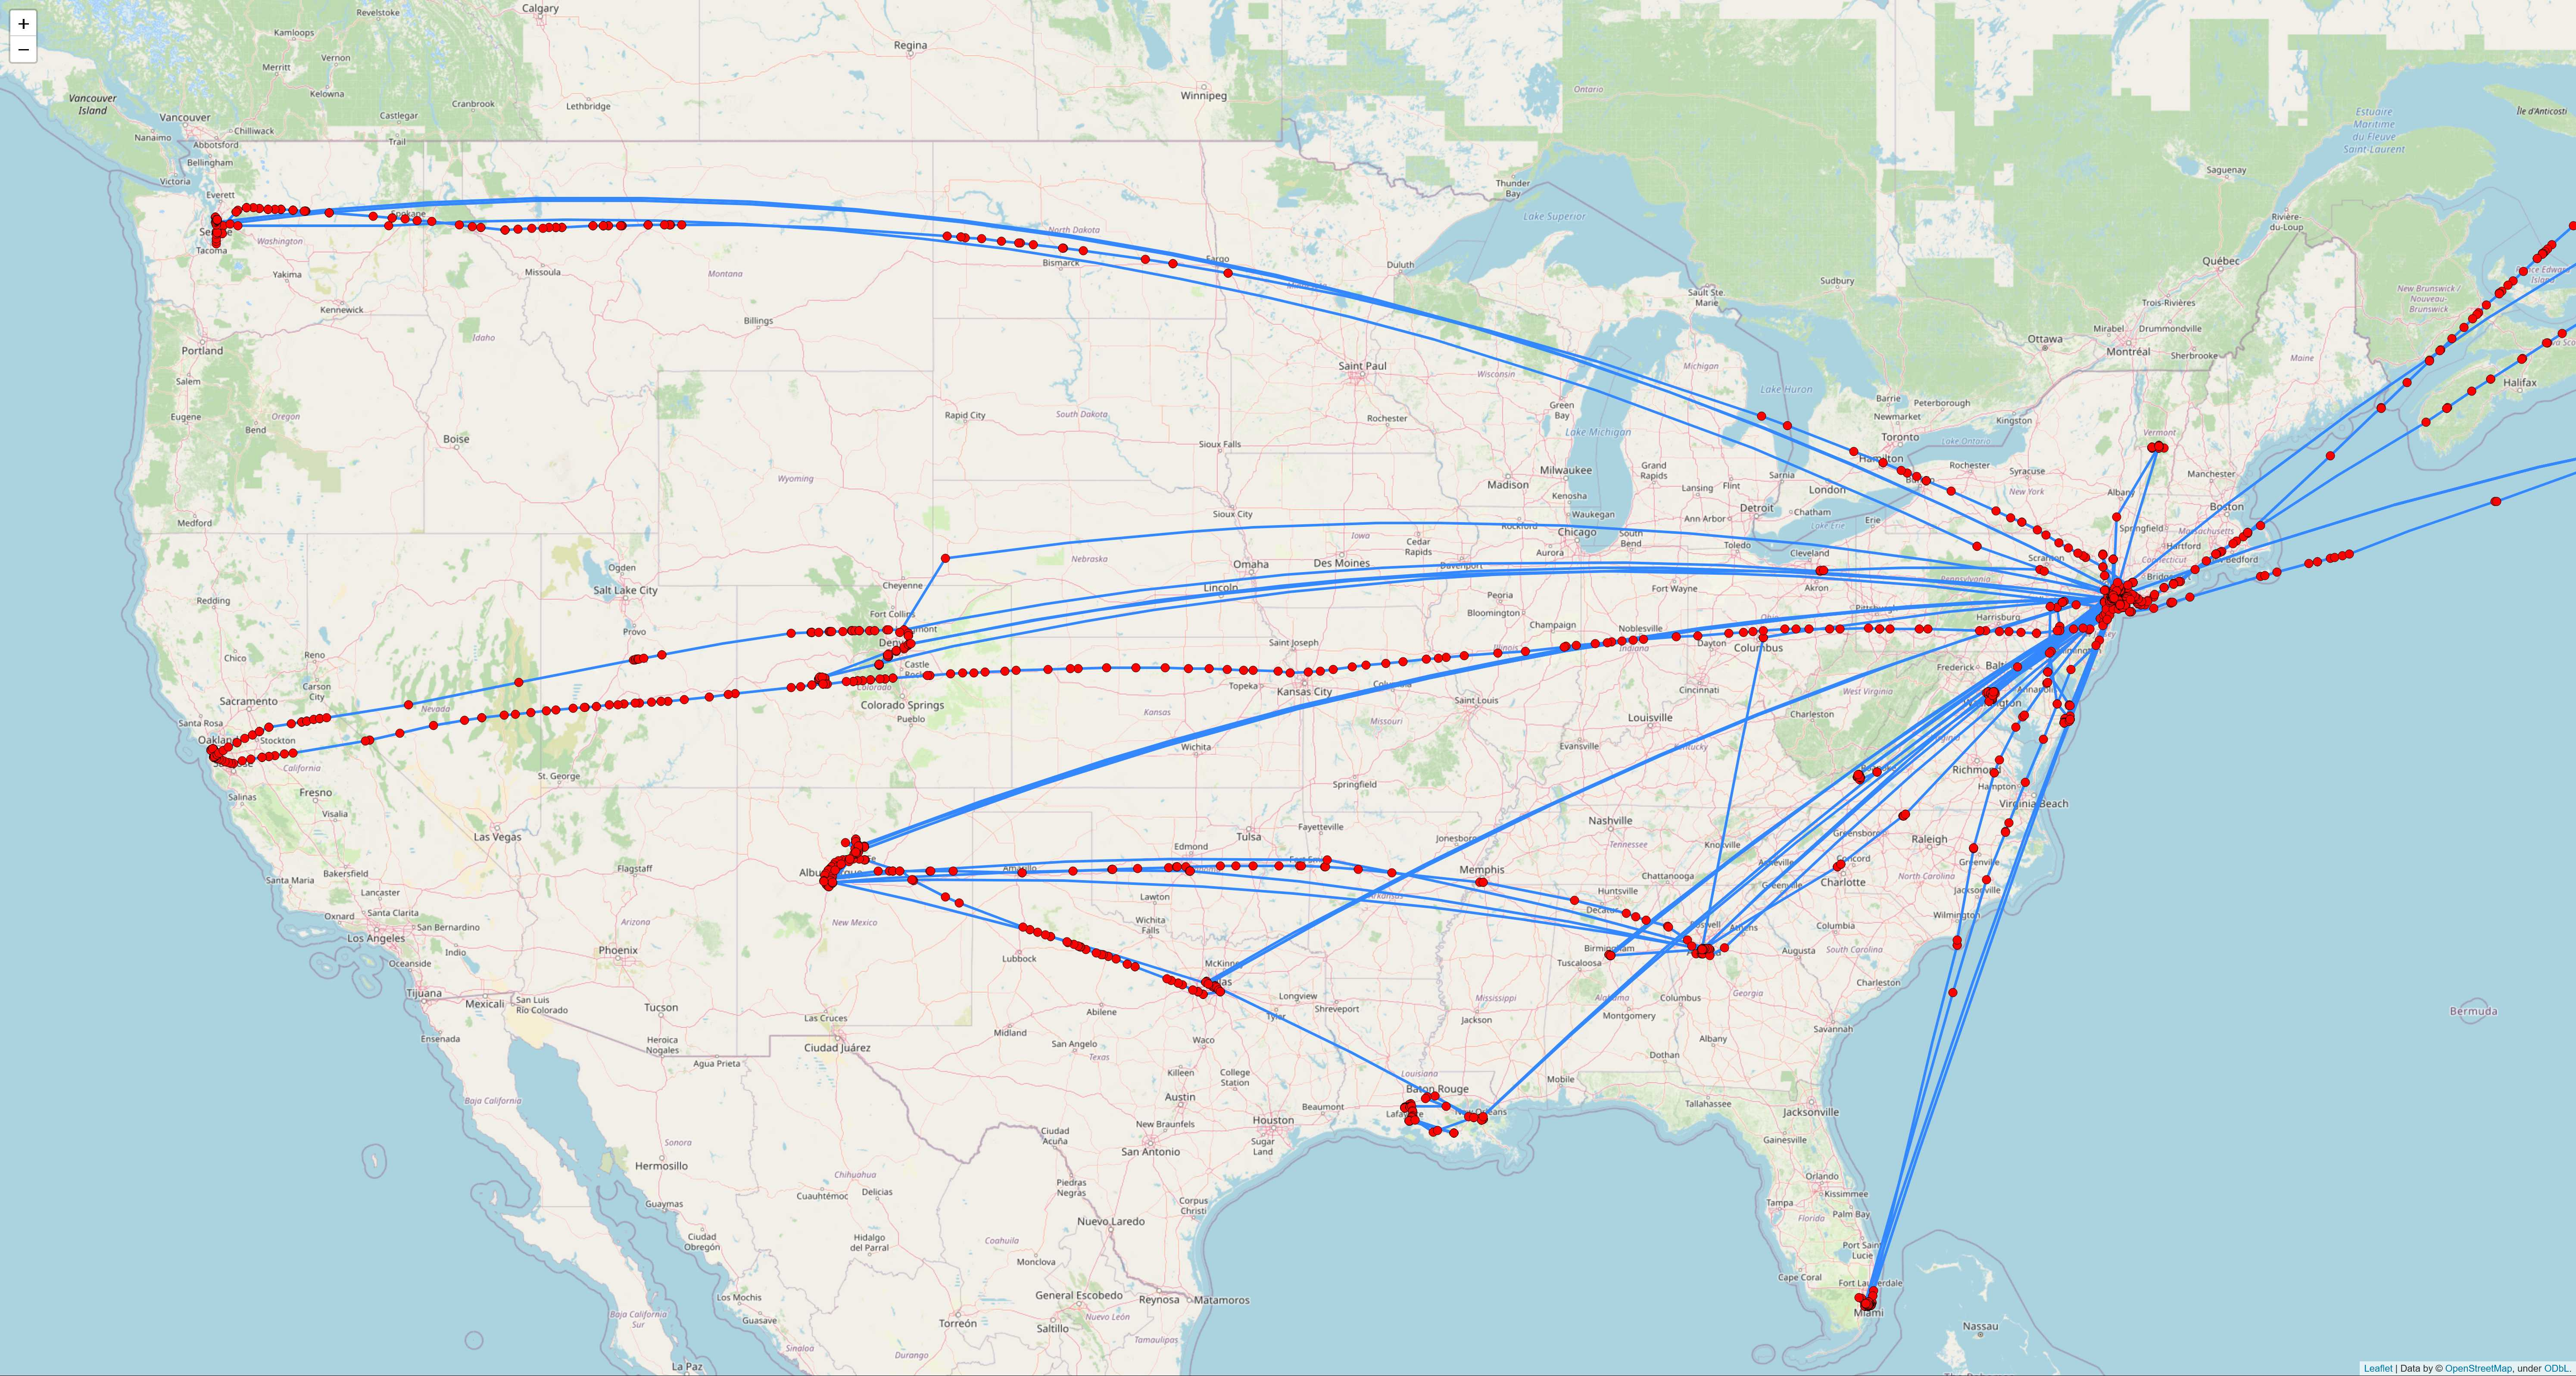

In [31]:
IPython.display.display(IPython.display.Image(
    filename='smaller_screenshots/'+'2022_combined_locations.jpg'))

The code block below would display all maps within the smaller_screenshots folder via a for loop. However, I commented it out because running it prevented the notebook from displaying on GitHub. 

In [32]:
# for map in smaller_screenshot_list:
#     print(f'\n\n{map}:')
#     IPython.display.display(IPython.display.Image(
#         filename='smaller_screenshots/'+map))

# # This method of displaying images within a loop comes from Stack Overflow
# # user DrMcCleod at https://stackoverflow.com/a/35061341/13097194 .


## How far have I traveled each year?

Using this geotag data, I can also retrieve a rough estimate of how far I've traveled each year. I'll do so by using the calculate_distance_by_year() function to determine the distance in between each point, then sum up those distances for each year since 2012. (This requires that the points are sorted in chronological order, but I took care of that when creating df_locations.)

calculate_distance_by_year uses the haversine library to calculate the haversine/great-circle distance between points, which is more accurate than the Euclidean distance (given that the Earth is curved). This library also handles trips across the international date line well:



In [33]:
from haversine import haversine, Unit
prev_pt = [50, -170]
cur_pt = [50, 170]
haversine(prev_pt, cur_pt,
            unit = Unit.MILES)

885.5905764533472

Here's a table showing my estimate of the total distance (in miles) that I've traveled each year:

In [34]:
df_distances_by_year = calculate_distance_by_year(
    df_locations)

df_distances_by_year

c:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\media_geotag_mapper\media_geotag_functions_v2.py:725: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0006619596408648121' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, dist_col] = haversine(prev_pt, cur_pt,


year  total_distance  geotags
0   2012     5014.949225     1447
1   2013    36790.651721     4199
2   2014    15786.288086     1729
3   2015    25156.937935      925
4   2016    27198.429042     2906
5   2017     3340.644422      251
6   2018    16385.524118      363
7   2019    11646.642038      310
8   2020    24352.713620     2251
9   2021    62677.469122     6015
10  2022   105728.547439    10471
11  2023    82166.308046     6517
12  2024      747.594811     1460

According to this estimate, I've traveled about 223,000 miles since 2012:

In [35]:
sum(df_distances_by_year['total_distance'])

416992.6996260217

How accurate are these estimates? They're certainly not perfect; after all, I don't take pictures and videos all the time when I travel (although I do take lots of them), and there are probably at least some points within my table that aren't in the correct order.

However, for comparison, I've flown 196,043 miles during this same timeframe (according to another spreadsheet), so the 223,000 figure is plausible. (The flights spreadsheet doesn't capture road and train trips, but df_distances_by_year does.)

I can also plot these yearly totals as a bar chart:

<BarContainer object of 13 artists>

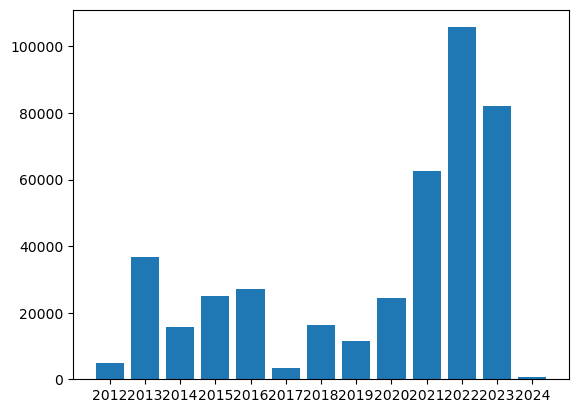

In [36]:
fig, axes = plt.subplots()
plt.bar(x = df_distances_by_year['year'].astype('str'), 
height = df_distances_by_year['total_distance'])

That's it for this tutorial program! I had a lot of fun creating it, and I hope that you'll enjoy using it to plot out your own journeys! 

In [37]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish
# When generate_new_lists was set to True, I received a run time of 
# 2222.32 seconds (37 minutes and 2.32 seconds).

Completed run at Sun Apr  7 00:45:39 2024 (local time)
Total run time: 3005.21 second(s) (50.0 minute(s) and 5.21 second(s))
